<a href="https://colab.research.google.com/github/musman2012/imaging-research/blob/master/OpenCV/WorkingwithOCTCroppedImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io

#matfile = io.loadmat('/content/2macula.mat')


In [3]:
import cv2 as cv

def detect_edges(img):    ## detecting edges
  sobelx = cv.Sobel(img,cv.CV_32F,1,0,ksize=3)
  sobely = cv.Sobel(img,cv.CV_32F,0,1,ksize=3)
  gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
  return gradmag

def return_binary(img):
  #kernel = np.ones((9, 9), np.uint8)
  #gradient = cv.morphologyEx(img, cv.MORPH_GRADIENT, kernel)
  kernel1 = np.ones((5, 5), np.uint8)
  #dilation = cv.erode(gradient, kernel1, iterations=2)
  dilation = cv.erode(img, kernel1, iterations=1)
  #final = gradient-dilation
  edges = cv.Canny(dilation, 60, 60)
  #cv.imwrite("edges.png",edges)
  ret, binary = cv.threshold(edges, 15, 255, cv.THRESH_BINARY)
  return (ret, binary)

In [5]:
normal_img_path = '/content/DH000.tif'
abnormal_img_path = '/content/DH014.tif'
FILTER_INTENSITY = 25
img = cv.imread(normal_img_path)
img = img[150:480,500:,:]
oneimage = cv.fastNlMeansDenoisingColored(img, None, FILTER_INTENSITY,10,7,21)
grad1 = detect_edges(img)
#print(grad1)
grad_denoise = detect_edges(oneimage)

cv.imwrite("magnitude_dn.png", grad_denoise)
cv.imwrite("magnitude.png", grad1)



True

In [6]:
(ret1, binary1) = return_binary(img)
(ret_dn, binary_dn) = return_binary(oneimage)
cv.imwrite("binary.png",binary1)
cv.imwrite("binary_dn.png",binary_dn)

True

In [17]:
img_an = cv.imread(abnormal_img_path)
img_an = img_an[50:480,500:,:]
oneimage_an = cv.fastNlMeansDenoisingColored(img_an,None, FILTER_INTENSITY,10,7,21)
grad1_an = detect_edges(img_an)
grad_denoise_an = detect_edges(oneimage_an)
cv.imwrite("magnitude_dn_an.png", grad_denoise_an)
cv.imwrite("magnitude_an.png", grad1_an)

True

In [13]:
(ret1_an, binary1_an) = return_binary(img_an)
(ret_dn_an, binary_dn_an) = return_binary(oneimage_an)
cv.imwrite("binary_an.png",binary1_an)
cv.imwrite("binary_dn_an.png",binary_dn_an)

True

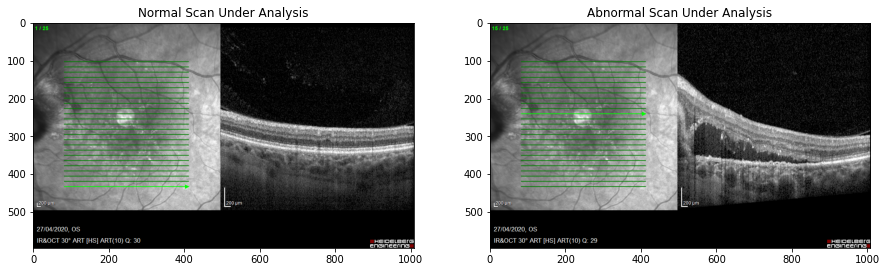

In [14]:
import matplotlib.image as mpimg

fig = plt.figure(figsize=(15, 15))

normal_img = mpimg.imread(normal_img_path)
ax = fig.add_subplot(1, 2, 1)
plt.imshow(normal_img)

abnormal_img = mpimg.imread(abnormal_img_path)
ax0 = fig.add_subplot(1, 2, 2)
plt.imshow(abnormal_img)

ax.title.set_text('Normal Scan Under Analysis')
ax0.title.set_text('Abnormal Scan Under Analysis')

plt.show()

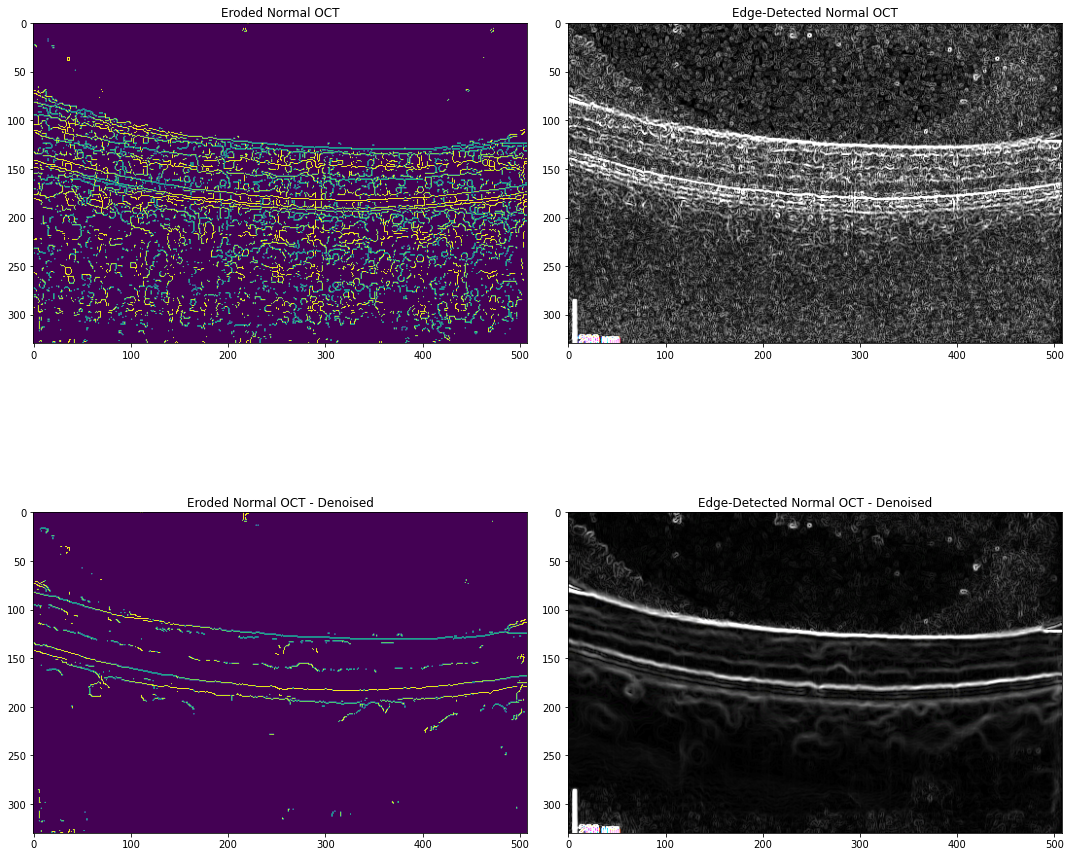

In [37]:
import matplotlib.image as mpimg

fig = plt.figure(figsize=(15, 15))
bin = mpimg.imread('/content/binary.png')
ax1 = fig.add_subplot(2, 2, 1)
plt.imshow(bin)
mag = mpimg.imread('/content/magnitude.png')
ax2 = fig.add_subplot(2, 2, 2)
plt.imshow(mag)
bin_dn = mpimg.imread('/content/binary_dn.png')
ax3 = fig.add_subplot(2, 2, 3)
plt.imshow(bin_dn)
mag_dn = mpimg.imread('/content/magnitude_dn.png')
ax4 = fig.add_subplot(2, 2, 4)
plt.imshow(mag_dn)
ax1.title.set_text('Eroded Normal OCT')
ax2.title.set_text('Edge-Detected Normal OCT')
ax3.title.set_text('Eroded Normal OCT - Denoised')
ax4.title.set_text('Edge-Detected Normal OCT - Denoised')
plt.tight_layout()
plt.show()


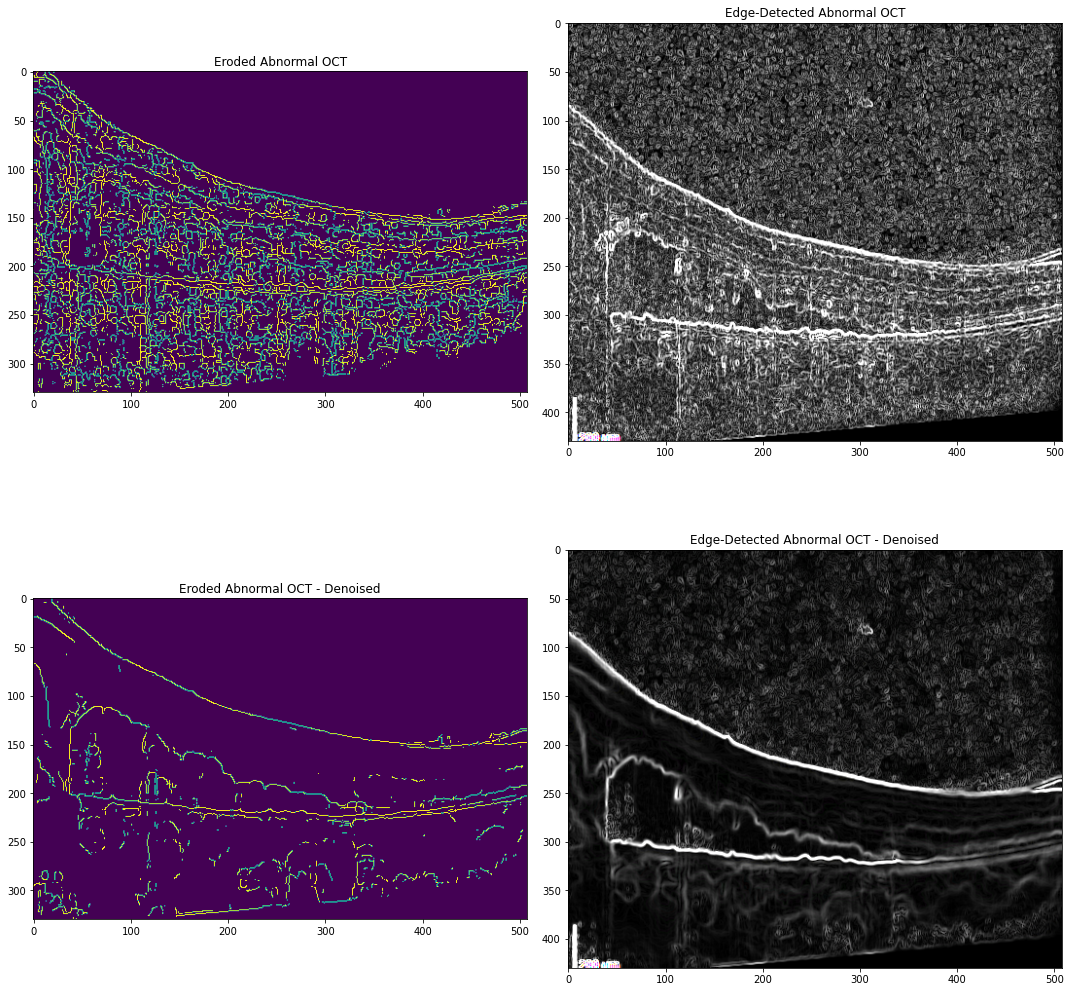

In [36]:
import matplotlib.image as mpimg

fig = plt.figure(figsize=(15, 15))
bin_an = mpimg.imread('/content/binary_an.png')
ax5 = fig.add_subplot(2, 2, 1)
plt.imshow(bin_an)
mag_an = mpimg.imread('/content/magnitude_an.png')
ax6 = fig.add_subplot(2, 2, 2)
plt.imshow(mag_an)
bin_dn_an = mpimg.imread('/content/binary_dn_an.png')
ax7 = fig.add_subplot(2, 2, 3)
plt.imshow(bin_dn_an)
mag_dn_an = mpimg.imread('/content/magnitude_dn_an.png')
ax8 = fig.add_subplot(2, 2, 4)
plt.imshow(mag_dn_an)
ax5.title.set_text('Eroded Abnormal OCT')
ax6.title.set_text('Edge-Detected Abnormal OCT')
ax7.title.set_text('Eroded Abnormal OCT - Denoised')
ax8.title.set_text('Edge-Detected Abnormal OCT - Denoised')
plt.tight_layout()
plt.show()

In [33]:
def apply_waterShed(img):
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
  #thresh = img
  # noise removal
  kernel = np.ones((2,2),np.uint8)
  #opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
  closing = cv.morphologyEx(thresh,cv.MORPH_CLOSE,kernel, iterations = 2)

  # sure background area
  sure_bg = cv.dilate(closing,kernel,iterations=3)

  # Finding sure foreground area
  dist_transform = cv.distanceTransform(sure_bg,cv.DIST_L2,3)

  # Threshold
  ret, sure_fg = cv.threshold(dist_transform,0.1*dist_transform.max(),255,0)

  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv.subtract(sure_bg,sure_fg)

  # Marker labelling
  ret, markers = cv.connectedComponents(sure_fg)

  # Add one to all labels so that sure background is not 0, but 1
  markers = markers+1

  # Now, mark the region of unknown with zero
  markers[unknown==255] = 0

  markers = cv.watershed(img,markers)
  img[markers == -1] = [255,0,0]

  return img


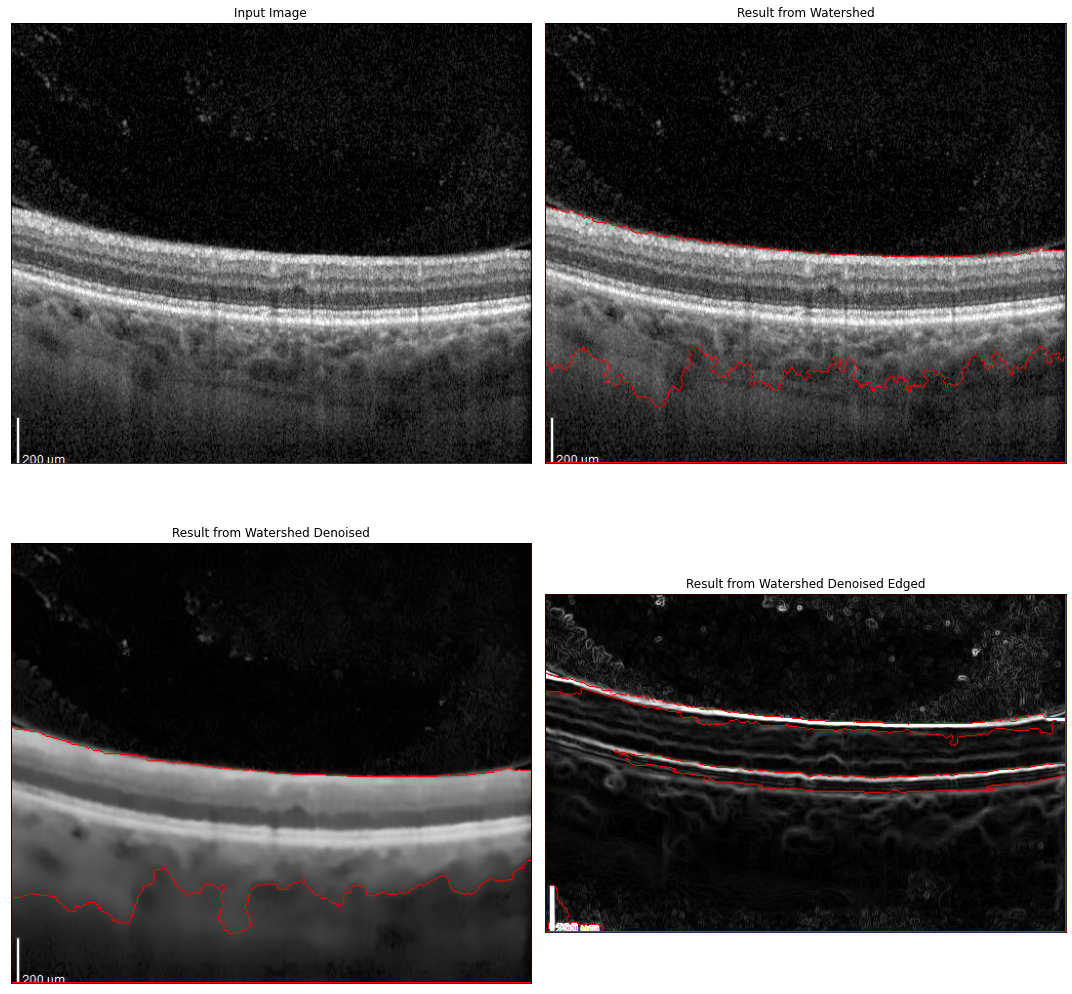

In [40]:
img = cv.imread('/content/DH000.tif') 
edge_img = cv.imread('/content/magnitude_dn.png')
img = img[50:480,500:,:]
b,g,r = cv.split(img)
rgb_img = cv.merge([r,g,b])

img_dn = cv.fastNlMeansDenoisingColored(img, None, FILTER_INTENSITY,10,7,21)
img = apply_waterShed(img)
dn_ws = apply_waterShed(img_dn)
edge_img = apply_waterShed(edge_img)

fig = plt.figure(figsize=(15, 15))

plt.subplot(221),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])


plt.subplot(222),plt.imshow(img, 'gray')
plt.title("Result from Watershed"), plt.xticks([]), plt.yticks([])

plt.subplot(223),plt.imshow(dn_ws, 'gray')
plt.title("Result from Watershed Denoised"), plt.xticks([]), plt.yticks([])

plt.subplot(224),plt.imshow(edge_img, 'gray')
plt.title("Result from Watershed Denoised Edged"), plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()